In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

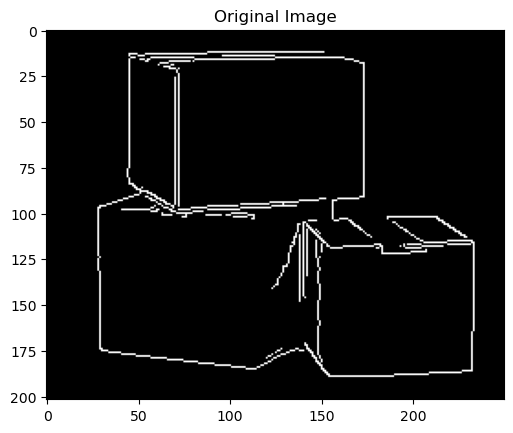

In [2]:
box = cv2.imread('box.jpg', cv2.IMREAD_GRAYSCALE)
box_canny = cv2.Canny(box, 100, 200)   # Edge detection by Canny
box_bin = np.array(box_canny)
box_bin[box_bin > 0] = 1 

plt.figure()
plt.imshow(box_bin, cmap='gray')
plt.title("Original Image")
plt.show()

In [3]:
theta_res = 0.1 # thetas: [-90, -90+theta_res, ... , 90-theta_res, 90]
rho_res = 1 # rhos: [-diag, -diag+rho_res, ... , diag-rho_res, diag]
img_row, img_col = box_bin.shape

# Theta for Hough space
theta_num = int(180 / theta_res + 1)
thetas = np.linspace(-90, 90, theta_num)
thetas[thetas==0.] = theta_res / 10 # Deal with Divide-by-0 problem
thetas_rad = np.deg2rad(thetas)

# Rho for Hough space
diag = int(np.sqrt(img_row**2 + img_col**2))
rho_num = int(2 * diag / rho_res + 1)
rhos = np.linspace(-diag, diag, rho_num)

hough_space = np.zeros((rho_num, theta_num))
for r in range(img_row):
    for c in range(img_col):
        if box_bin[r, c]: # Search for pixels in edges
            for theta_idx, rad in enumerate(thetas_rad):
                hough_sinusoid = c * np.cos(rad) + r * np.sin(rad)
                rho_idx = np.argmin(abs(rhos - hough_sinusoid)) # Find the closest rho
                hough_space[rho_idx, theta_idx] += 1

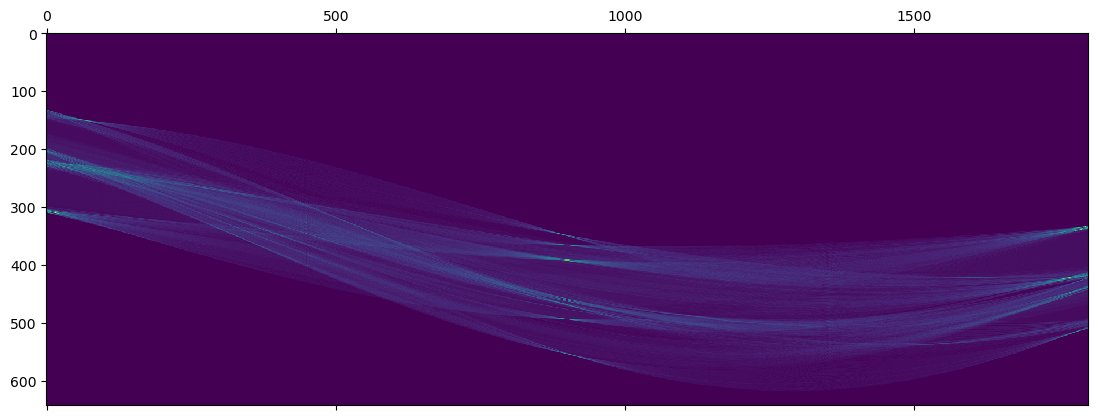

In [4]:
plt.matshow(hough_space)
plt.show()

In [5]:
num = 10    # Number of Hough lines
threshold = 50  # To avoid duplicated Hough lines
hough_line_idx = [] # Array to save rho & theta of Hough lines

hough_tmp = hough_space.copy()
while len(hough_line_idx) < num:
    rho_idx, theta_idx = np.unravel_index(hough_tmp.argmax(), hough_tmp.shape)
    if len(hough_line_idx) == 0:
        hough_line_idx.append([rho_idx, theta_idx])
    else:
        tmp_idx = np.array(hough_line_idx)
        thr = abs(rhos[tmp_idx[:, 0]] - rhos[rho_idx]) + abs(thetas[tmp_idx[:, 1]] - thetas[theta_idx])
        if np.min(thr) > threshold:
            hough_line_idx.append([rho_idx, theta_idx])
        else:
            hough_tmp[rho_idx, theta_idx] = 0

hough_line_idx = np.array(hough_line_idx)

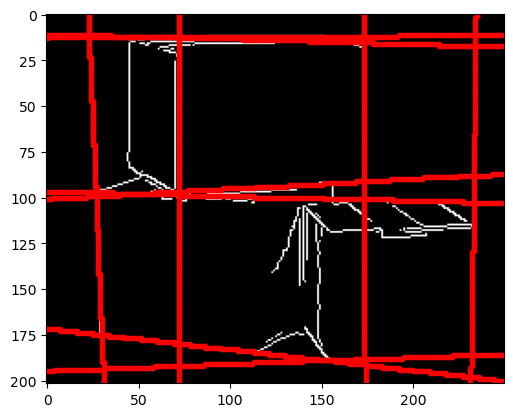

In [6]:
hough_line_rhos = rhos[hough_line_idx[:, 0]]
hough_line_thetas = thetas_rad[hough_line_idx[:, 1]]

m = -np.cos(hough_line_thetas) / np.sin(hough_line_thetas)
c = hough_line_rhos / np.sin(hough_line_thetas)

plt.figure()
plt.imshow(box_bin, cmap="gray")
for i in range(len(m)):
    for col in range(img_col):
        y = int(m[i] * col + c[i])
        if 0 <= y < img_row:
            plt.plot(col, y, marker='.', color="red")
    for row in range(img_row):
        x = int((row - c[i]) / m[i])
        if 0 <= x < img_col:
            plt.plot(x, row, marker = '.', color="red")
plt.show()